In [1]:
import numpy as np
import pandas as pd
import sorobn as hh
import graphviz

Задание построить случайную BN и сгенерировать датасет. Потом посчитать likelihood этого датасета, сравнить со случайными данными. Далее конвертировать построенную BN в MRF и посчитать по ней likelihood сгенеренных данных и снова сравнить со случайными. И повторить эксперимент несколько раз

In [2]:
def p_table_index(n):
    assert n >= 1
    if n == 1:
        return [False, True]
    elif n == 2:
        return [(False, False), (False, True), (True, False), (True, True)]
    else:
        ix = p_table_index(n-1)
        return [(False,) + p for p in ix] + [(True,) + p for p in ix]

def rand_p_table(n):
    ix = p_table_index(n)
    p = np.zeros(len(ix))
    p[::2] = np.random.uniform(0, 1, len(ix)//2)
    p[1::2] = 1 - p[::2]
    return pd.Series({k : v for k, v in zip(ix, p)})

def rand_data(k, n):
    return pd.DataFrame({chr(ord('A')+i) : 
                         np.random.randint(0, 2, n, dtype=bool) 
                         for i in range(k)})

Для BN воспользуемся библиотекой sorobn. Случайные BN будут иметь вручную заданную топологию, но все вероятности внутри - случайны и генерируются с помощью методов сверху.

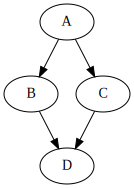

In [3]:
bn = hh.BayesNet(
    ('A', ['B', 'C']),
    (['B', 'C'], 'D'),
    seed=42,
)

bn.P['A'] = rand_p_table(1)
bn.P['B'] = rand_p_table(2)
bn.P['C'] = rand_p_table(2)
bn.P['D'] = rand_p_table(3)
bn.prepare()

bn.graphviz()

Посчитаем средний log lieklihood сэмпла сгенерированного моделью. Также оценим погрешность этого среднего (std of mean) для этого просто разделим std на корень из размера сэмпла.

In [4]:
sample = bn.sample(1000)
ll = bn.predict_log_proba(sample)
print(f'Sample LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

rand = rand_data(4, 1000)
ll = bn.predict_log_proba(rand)
print(f'Rand LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

Sample LL: mean = -2.352 ± 0.0197
Rand LL: mean = -3.359 ± 0.0408


Как видно likelihood сэмпла из распределения гораздо выше сэмпла извне распределения (разница значительно превышает сумму погрешностей)

Я не стал писать общий метод для конвертации BN в MRF, это показалось мне слишком сложным, поэтому я просто для каждого эксперимента вручную напишу функции $\psi$ и посчитаю Z

In [5]:
def psi_ABC(A, B, C):
    return bn.P['A'].loc[A] * bn.P['B'].loc[A, B] * bn.P['C'].loc[A, C]

def psi_BCD(B, C, D):
    return bn.P['D'].loc[B, C, D]

def psi(A, B, C, D):
    return psi_ABC(A, B, C) * psi_BCD(B, C, D)

ix = p_table_index(4)
Z = sum(psi(*x) for x in ix)
print(f'Z = {Z}')

ll = [np.log(psi(*s)) for s in sample.values]
ll = pd.Series(ll)
print(f'Sample LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

ll = [np.log(psi(*s)) for s in rand.values]
ll = pd.Series(ll)
print(f'Rand LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

Z = 1.0000000000000002
Sample LL: mean = -2.352 ± 0.0197
Rand LL: mean = -3.359 ± 0.0408


Поскольку я конвертировал BN в MRF то вероятности не поменялись. Вроде так и должно было произойти. Также, как видно, Z получилась равной 1 - это еще один индикатор того, что конвертация прошла успешно.

Давайте проведем этот эксперимент на еще парочке сетей

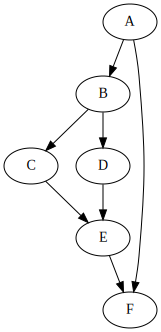

In [6]:
bn = hh.BayesNet(
    ('A', ['B', 'F']),
    ('B', ['C', 'D']),
    (['C', 'D'], 'E'),
    ('E', 'F'),
    seed=42,
)

bn.P['A'] = rand_p_table(1)
bn.P['B'] = rand_p_table(2)
bn.P['C'] = rand_p_table(2)
bn.P['D'] = rand_p_table(2)
bn.P['E'] = rand_p_table(3)
bn.P['F'] = rand_p_table(3)
bn.prepare()

bn.graphviz()

In [7]:
sample = bn.sample(1000)
ll = bn.predict_log_proba(sample)
print(f'Sample LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

rand = rand_data(6, 1000)
ll = bn.predict_log_proba(rand)
print(f'Rand LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

Sample LL: mean = -2.432 ± 0.0436
Rand LL: mean = -6.626 ± 0.0769


Для нагляднсти вот граф MRF

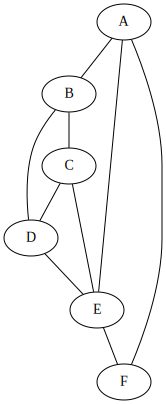

In [8]:
dot = graphviz.Graph('MRF graph')
dot.node('A', 'A')
dot.node('B', 'B')
dot.node('C', 'C')
dot.node('D', 'D')
dot.node('E', 'E')
dot.node('F', 'F')
dot.edges(['AE', 'AB', 'BC', 'BD', 'CD', 'CE', 'DE', 'EF', 'AF'])
dot

In [9]:
def psi_AB(A, B):
    return bn.P['A'].loc[A] * bn.P['B'].loc[A, B]

def psi_BCD(B, C, D):
    return bn.P['C'].loc[B, C] * bn.P['D'].loc[B, D]

def psi_CDE(C, D, E):
    return bn.P['E'].loc[C, D, E]

def psi_AEF(A, E, F):
    return bn.P['F'].loc[A, E, F]

def psi(A, B, C, D, E, F):
    return psi_AB(A, B) * psi_BCD(B, C, D) * psi_CDE(C, D, E) * psi_AEF(A, E, F)

ix = p_table_index(6)
Z = sum(psi(*x) for x in ix)
print(f'Z = {Z}')

ll = [np.log(psi(*s)) for s in sample.values]
ll = pd.Series(ll)
print(f'Sample LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

ll = [np.log(psi(*s)) for s in rand.values]
ll = pd.Series(ll)
print(f'Rand LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

Z = 0.9999999999999998
Sample LL: mean = -2.432 ± 0.0436
Rand LL: mean = -6.626 ± 0.0769


Как и ожидалось, получили те же значения. Последний эксперимент

In [10]:
bn = hh.BayesNet(
    ('A', ['B', 'C', 'D', 'E']),
    (['B', 'C'], 'F'),
    (['D', 'E'], 'G'),
    (['F', 'C', 'D', 'G'], 'H'),
    seed=42,
)

bn.P['A'] = rand_p_table(1)
bn.P['B'] = rand_p_table(2)
bn.P['C'] = rand_p_table(2)
bn.P['D'] = rand_p_table(2)
bn.P['E'] = rand_p_table(2)
bn.P['F'] = rand_p_table(3)
bn.P['G'] = rand_p_table(3)
bn.P['H'] = rand_p_table(5)
bn.prepare()

![](BN_and_MRF_graphs.jpg "BN and MRF graphs")

In [11]:
sample = bn.sample(1000)
ll = bn.predict_log_proba(sample)
print(f'Sample LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

rand = rand_data(8, 1000)
ll = bn.predict_log_proba(rand)
print(f'Rand LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

Sample LL: mean = -3.327 ± 0.0475
Rand LL: mean = -8.944 ± 0.0904


In [13]:
def psi_ABCDE(A, B, C, D, E):
    return bn.P['A'].loc[A] * bn.P['B'].loc[A, B] * bn.P['C'].loc[A, C] * bn.P['D'].loc[A, D] * bn.P['E'].loc[A, E]

def psi_BCF(B, C, F):
    return bn.P['F'].loc[B, C, F]

def psi_DEG(D, E, G):
    return bn.P['G'].loc[D, E, G]

def psi_CDFGH(C, D, F, G, H):
    return bn.P['H'].loc[C, D, F, G, H]

def psi(A, B, C, D, E, F, G, H):
    return psi_ABCDE(A, B, C, D, E) * psi_BCF(B, C, F) * psi_DEG(D, E, G) * psi_CDFGH(C, D, F, G, H)

ix = p_table_index(8)
Z = sum(psi(*x) for x in ix)
print(f'Z = {Z}')

ll = [np.log(psi(*s)) for s in sample.values]
ll = pd.Series(ll)
print(f'Sample LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

ll = [np.log(psi(*s)) for s in rand.values]
ll = pd.Series(ll)
print(f'Rand LL: mean = {ll.mean():.3f} ± {ll.std() / len(ll)**.5:.3}')

Z = 1.0
Sample LL: mean = -3.327 ± 0.0475
Rand LL: mean = -8.944 ± 0.0904
